# Project Title

## Overview



To find potential factors in vaccine hesistancy in the COVID-19 pandemic, we used a dataset of characteristics of people who either got the H1N1 or didn't. We tested different machine learning models on the dataset for prediction accuracy and ended up choosing a ____ model.  

## Business Problem


The CDC has hired us as data scientists to find lessons from the H1N1 pandemic. Early into the vaccine rollout, there has been massive public skepticism of the vaccine, slowing our ability to overcome the virus and re-open the country.

We have received a large dataset from 2009, with statistical information and pandemic/H1N1 scaled opinions for each respondent. This data includes whether each person was vaccinated or not, which will allow us to predict who gets the vaccine.

This model will allow the CDC to determine investments in public health awareness, surveying and modelling during the pandemic, based on the parameters which impact an individuals vaccine choice the most. 



## Data Understanding

The dataset includes 26,000 respondents responses, and includes 34 different characteristics. They provide demographic information such as age, sex, race, income, and education and also include opinion and knowledge assessment on the risk of the H1N1 virus. 

The data can be found at https://www.drivendata.org/competitions/66/flu-shot-learning/ 


The target variable is the 'h1n1 vaccine' column. It is binary: 0 means the respondent didn't get the vaccine and 1 means they did. 

One things we are going to try to reduce is the prediction of False Negatives where the model predicted someone didn't get the H1N1 Vaccine but they actually in truth did recieve the vaccine. False positives or when the model predics someone getting the vaccine but in reallity did not recieve a H1N1 vaccine. Having too many False Negatives or False Positives could render our predictive model useless for targeting Vaccine hesitence. 

In [1]:
# We'll import the dataframe with Pandas. 
import numpy as np
import pandas as pd

data = pd.read_csv('Data/training_set_features.csv', index_col='respondent_id')       # Included only columns we want to use as features for our model
target = pd.read_csv('Data/training_set_labels.csv', index_col='respondent_id')       # Target Columns
holdout_set = pd.read_csv('Data/test_set_features.csv', index_col='respondent_id')    # A data frame that will remain untouched in order to test final model 

# Take a quick look at
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

## Data Preparation

Describe and justify the process for preparing the data for analysis.

As the dataset also includes information on whether the respondent got the seasonal flu vaccine and their scaled opinions on the seasonal vaccine, we decided to drop all data and focus on h1n1-related data for model simplicity.

We then decided to drop the health insurance column as there were many null values, and in initial data modelling our model was much more accurate with it gone.

The data left is a combination of ordinal (>2 non-continuous) and binary variables, both in string and number format. We converted all string data to integers, i.e. 'Male' and 'Female' in the 'sex' column converted to 0 and 1, respectively.

For remaining missing values in columns, we filled in the mode of the dataset. 


Text(0, 0.5, 'h1n1_vaccine')

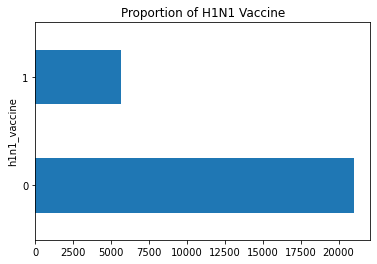

In [2]:
# Dropping all columns that are related to the seasonal flue target
data.drop(columns=[
    'hhs_geo_region',
    'census_msa', 
    'employment_industry', 
    'employment_occupation', 
    'opinion_seas_vacc_effective', 
    'opinion_seas_risk', 
    'opinion_seas_sick_from_vacc', 
    'health_insurance', 
    'doctor_recc_seasonal'], inplace=True)

# We only need the 'h1n1_vaccine' column as our target variable so we'll turn it into a panda series with just that column. 
target = pd.Series(target['h1n1_vaccine'])

# Visualize the target variable
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
target.value_counts().plot.barh(title="Proportion of H1N1 Vaccine", ax=ax)
ax.set_ylabel("h1n1_vaccine")



In [3]:
# inspect the values 
target.value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

## Baseline Model

We examined how accurately a decision tree-based model would be able to determine if someone got vaccinated or not based on their characteristics.

In this case we dropped rows with missing values and used pd.get_dummies to split up the ordinal variables with 3 or more values.

Train accuracy score: 0.8396076998050682
Test accuracy score: 0.8210891812865497


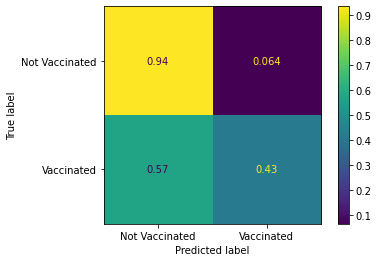

In [4]:
#convert all object columns to dummies
features = data
features = pd.get_dummies(features,columns = ['employment_status','age_group','education','race','income_poverty'])


#convert sex to binary, 0: male, 1:female
features['sex'] = features['sex'].replace({'Female':1,'Male':0})
features['sex'] = pd.to_numeric(features['sex'])
#convert marital status to binary, 0: single, 1:married
features['marital_status'] = features['marital_status'].replace({'Married':'1','Not Married':'0'})
features['marital_status'] = features['marital_status'].astype(int,errors='ignore')


# convert rent or own to binary: 0 rent, 1 own
features['rent_or_own'] = features['rent_or_own'].replace({'Own':'1','Rent':'0'})
features['rent_or_own'].astype(int,errors='ignore',copy=False)

features = features.astype('float64')
merge_df = features.merge(target,how='left',on='respondent_id')
merge_df.dropna(inplace=True)
merge_df.describe()

#split back into X,y

y = merge_df['h1n1_vaccine']
X = merge_df.drop('h1n1_vaccine',axis=1,inplace=False) 

#train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25)

#instantiate decisiontree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

tree_clf = DecisionTreeClassifier(criterion='gini',max_depth=7,random_state =42 )
tree_clf.fit(X_train,y_train)

plot_confusion_matrix(tree_clf,X_test,y_test, normalize='true', display_labels=['Not Vaccinated', 'Vaccinated'])

#training accuracy score
print("Train accuracy score:", tree_clf.score(X_train,y_train))

#testing accuracy score
print("Test accuracy score:", tree_clf.score(X_test,y_test))

There is a good amount of false positives so we'll try adjusting the model a little bit 

We'll try a bagging the desician tree model

Train accuracy score: 0.846917641325536
Test accuracy score: 0.8216374269005848
accuracy: 0.8216374269005848
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4234
           1       0.66      0.44      0.53      1238

    accuracy                           0.82      5472
   macro avg       0.75      0.69      0.71      5472
weighted avg       0.81      0.82      0.81      5472



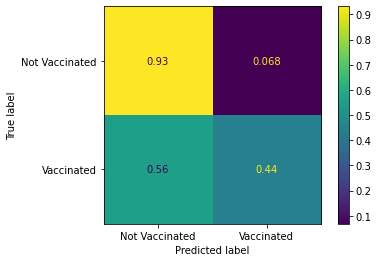

In [5]:
#bagging model overview
from sklearn.ensemble import BaggingClassifier
#instantiate bagging on tree_clf model
btc = BaggingClassifier(tree_clf,random_state =42 )
#fit bagging classifier to train
btc.fit(X_train,y_train)
#training accuracy score
print("Train accuracy score:", btc.score(X_train,y_train))
#testing accuracy score
print("Test accuracy score:",btc.score(X_test,y_test))
#predict
btc_pred = btc.predict(X_test)
from sklearn.metrics import accuracy_score 
print("accuracy:", accuracy_score(y_test,btc_pred, normalize='true'))
plot_confusion_matrix(btc,X_test,y_test, normalize='true', display_labels=['Not Vaccinated', 'Vaccinated'])

from sklearn.metrics import classification_report
print(classification_report(y_test, btc_pred))

The Bagging Classifier didn't really help our model it just slightly reduced the False Negatives but we're gona try something that will give use less False Negatives and ideally more True Positives. 

## Model Iterations

The above Decision Tree and Bagging classification models didn't give us the results we wanted so lets try a different approach involving Logestic Regression and Pipelines.


We set up a Machine learning Pipeline using SkLearn in order to easily run different models without changing too much code. 

The first step in the Pipeline is the Preprossessing stage when we convert categorical data into none ordinal numbers and we will also scale the numeric columns. The preprosessing step also deals with missing values. We will not be dealing with the modded dataframe from the previous model with the dummies collumns but instead untouched data. 


Instead of using dummies collumns for the categorical data we will use encoders from Sklearn and also scale the numerica columns because we are gona use Logestic Regression. We will also manually take the Odinal categorical columns and convert them to ordered integers. 

In [6]:
# code inspired from https://www.drivendata.co/blog/predict-flu-vaccine-data-benchmark/

# new names for dataframe to avoid confusion and resusing data 
X_clean = data
y_clean = target


# create lists containing names of related columns for transformation 
num_cols = data.select_dtypes('number').columns
ord_cols = ['age_group', 'education',  'income_poverty', 'employment_status']
cat_cols = ['race', 'sex', 'marital_status', 'rent_or_own'] 

# transformer ordinal columns into ordinal categories

age_group_dict = {
np.NAN: -1, 
'18 - 34 Years': 1, 
'35 - 44 Years': 2, 
'45 - 54 Years': 3, 
'55 - 64 Years': 4, 
'65+ Years': 5}

X_clean['age_group_ordinal'] = X_clean.age_group.map(age_group_dict).astype("category")
X_clean.drop(columns='age_group', inplace=True)

education_dict = {
    np.NAN: -1,
    '< 12 Years': 1, 
    '12 Years': 2, 
    'Some College': 3, 
    'College Graduate': 4}

X_clean['education_ordinal'] = X_clean.education.map(education_dict).astype("category")
X_clean.drop(columns='education', inplace=True)


income_dict = {
    np.NAN: -1,
    'Below Poverty': 1, 
    '<= $75,000, Above Poverty': 2, 
    '> $75,000': 3}

X_clean['income_poverty_ordinal'] = X_clean.income_poverty.map(income_dict).astype("category")
X_clean.drop(columns='income_poverty', inplace=True)

employment_dict = { 
    np.NAN: -1,
    'Unemployed': 1, 
    'Not in Labor Force': 2, 
    'Employed': 3}

X_clean['employment_status_ordinal'] = X_clean.employment_status.map(employment_dict).astype("category")
X_clean.drop(columns='employment_status', inplace=True)


# import neccessary libararies 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler


# first step on the Pipeline will be to deal with the categorical columns and scaling the numerical columns 
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))])

cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore'))])

# create the preprocessor stage of final pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, num_cols), 
        ('cat', cat_transformer, cat_cols)], remainder = "drop")


# The Next step in the Pipeline is the predictor. 
# We will use a Logistic Regression model to predict weather someone will get the H1N1 vaccine or not

from sklearn.linear_model import LogisticRegression

log_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
        ("classifier", LogisticRegression(random_state=52, class_weight='balanced'))])

Because this Pipeline has alot of hyperparamters we can tweak to try to get a better model we'll set up a Gridsearch to find the best parametrics that results in the best score. Gridsearch will take the dictionary 'log_param' as the different hyperparamters we want to try. 

In [7]:
# inprired by the code found at  https://towardsdatascience.com/ml-pipelines-with-grid-search-in-scikit-learn-2539d6b53cfb
log_param = {
        'preprocessor__numeric__simple_imputer__strategy': ["mean", "median", 'most_frequent', 'constant'], # Different ways to scale the numerical data.
        'preprocessor__cat__cat_imputer__strategy': ["mean", "median", 'most_frequent', 'constant'], # Different ways to transform the categorical data.
        'classifier__penalty': ['l1', 'l2'],                                # Method on how to deal with features with high Coefficient. 
        'classifier__C': [1.0, 2.0, 3.0, 5.0],                              # Setting regularization strength. 
        'classifier__max_iter': [50, 100, 1000, 10000],                     # Sets maximum number of itereations taken for solver to converge.
        'classifier__multi_class': ['ovr', 'multinomial'],                  # Sets how to define target class
        'classifier__solver': ['lbfgs', 'sag', 'saga', 'liblinear', 'newton-cg'] # Algorithm to use in the optimization problem
}
# we will now perform a train test split to make a terst set to run through the models
X_train_pipe, X_true_pipe, y_train_pipe, y_true_pipe = train_test_split(X_clean, y_clean, test_size=0.25, shuffle=True, stratify=target, random_state=42)

from sklearn.model_selection import GridSearchCV
# Initialize a Grid_Search object and pass thru the pipeline we set up and adjust the params we declared to be tweaked 
grid_search = GridSearchCV(estimator=log_pipeline, param_grid=log_param, cv=2, verbose=3,n_jobs=-1)
# fit the grid_search model with the training data set
grid_search.fit(X_train_pipe, y_train_pipe)

Fitting 2 folds for each of 5120 candidates, totalling 10240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1960 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3376 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4216 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 6392 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 7456 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 8912 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 10064 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 10225 out of 1024

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler()),
                                                                                         ('simple_imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'be...
                         'classifier__max_iter': [50, 100, 1000, 10000],
                         'classifier__multi_class': ['ovr', 'multinomial'],
  

As you can see the GridSearch Pipeline tried fitting over 10,000 models with the params we choose to try. 

## Finding the Best Model

With Grid Search we can easily get a configuration for the best Parametrics to use on our model. This saves us time because we can then take those parametrics and hard set it on a final model and perform our own evaluations. This way we don't have to recreate a bunch of models and evaluate each one. We will start evauluateing what the GridSearch has determined the best hyperparamterics. The important idea we are trying to achieve is to reduce the False Negatives. 

We will run a few evaluation metrics like ROC-AUC and plot another confusion matrix to see how many False Negatives showed up. If we find a model that significantly reduces the False Negatives we will go through more tests and evaluations. 

Score: 0.7749375936095857


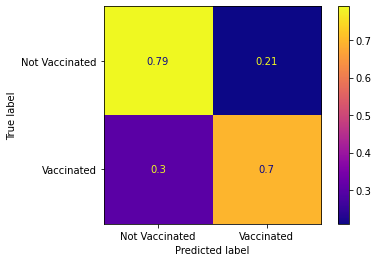

In [22]:
print('Score: ' + str(grid_search.best_score_))
plot_confusion_matrix(grid_search ,X_true_pipe, y_true_pipe, normalize='true', display_labels=['Not Vaccinated', 'Vaccinated'], cmap='plasma')


So with the best parameters coming from our GridSearchCV it is giving us a True Negative rate of 79% and a False Negative rate of 30% which is better than the 57% our baseline model gaves us so we are gona get those parameters and input them into a final Pipeline/ model. 

# Final Model

We will take the best parametrics from our GridSearch and fit them to a final Logestic Reggression model.

In [28]:
# Our final Pipeline will just be an edit of the last step in the previous Pipeline but with the best paramtrics added. 
best_param_setting = grid_search.cv_results_['params'][grid_search.best_index_]
print(best_param_setting)

{'classifier__C': 1.0, 'classifier__max_iter': 50, 'classifier__multi_class': 'ovr', 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'preprocessor__cat__cat_imputer__strategy': 'constant', 'preprocessor__numeric__simple_imputer__strategy': 'median'}


In [50]:
best_numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))])

best_cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore'))])

best_preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, num_cols), 
        ('cat', cat_transformer, cat_cols)], remainder = "drop")



best_log = LogisticRegression(max_iter=1000,                               
                              multi_class = 'ovr',
                              penalty = 'l1',
                              solver =  'saga',
                              random_state=42,)

In [51]:
# making new data for final split and model
X_final = best_preprocessor.fit_transform(X_clean)
X_train_final, X_true_final, y_train_final, y_true_final = train_test_split(X_final, y_clean, test_size=0.25, shuffle=True, stratify=target, random_state=42)

clf = best_log.fit(X_train_final, y_train_final)


In [56]:
clf.score(X_true_final, y_true_final)

0.8333083720233638

## Evaluation

With Grid Search we can easily get a configuration for the best Parametrics to use on our model. This saves us time because we can then take those parametrics and hard set it on a final model and perform our own evaluations. 



////////////////////////////////////

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

From a baseline understanding, the data set target is skewed towards those who didn't get the vaccine, 79% of respondents. 

In [ ]:
# code here to arrive at a baseline prediction

In [ ]:
# code here for your first 'substandard' model

In [ ]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
